## Настройка окружения

In [1]:
!nvidia-smi

Sun Mar  2 21:13:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

## Установка YOLO11

In [2]:
%pip install ultralytics supervision roboflow
import ultralytics
ultralytics.checks()

Ultralytics 8.3.82 🚀 Python-3.10.1 torch-2.5.1 CPU (Apple M1)
Setup complete ✅ (8 CPUs, 16.0 GB RAM, 210.8/228.3 GB disk)


## Тюнинг YOLO11 на своем датасете

In [ ]:
%pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="******") # нужен API-KEY с Roboflow
project = rf.workspace("razmetka-dj4rc").project("pestrian-volume-csmbx")
version = project.version(1)
dataset = version.download("yolov11")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Pestrian-volume-1 in yolov11:: 100%|██████████| 3040/3040 [00:00<00:00, 4941.75it/s]


## Обучение

In [ ]:
!cd {HOME}

!yolo task=detect mode=train model=yolo11m.pt data={dataset.location}/data.yaml epochs=10 imgsz=640 plots=True

In [6]:
!ls {HOME}/runs/detect/train/

args.yaml					    PR_curve.png	   val_batch0_pred.jpg
confusion_matrix_normalized.png			    R_curve.png		   val_batch1_labels.jpg
confusion_matrix.png				    results.csv		   val_batch1_pred.jpg
events.out.tfevents.1740950240.6422bbd95e89.1615.0  results.png		   val_batch2_labels.jpg
F1_curve.png					    train_batch0.jpg	   val_batch2_pred.jpg
labels_correlogram.jpg				    train_batch1.jpg	   weights
labels.jpg					    train_batch2.jpg
P_curve.png					    val_batch0_labels.jpg


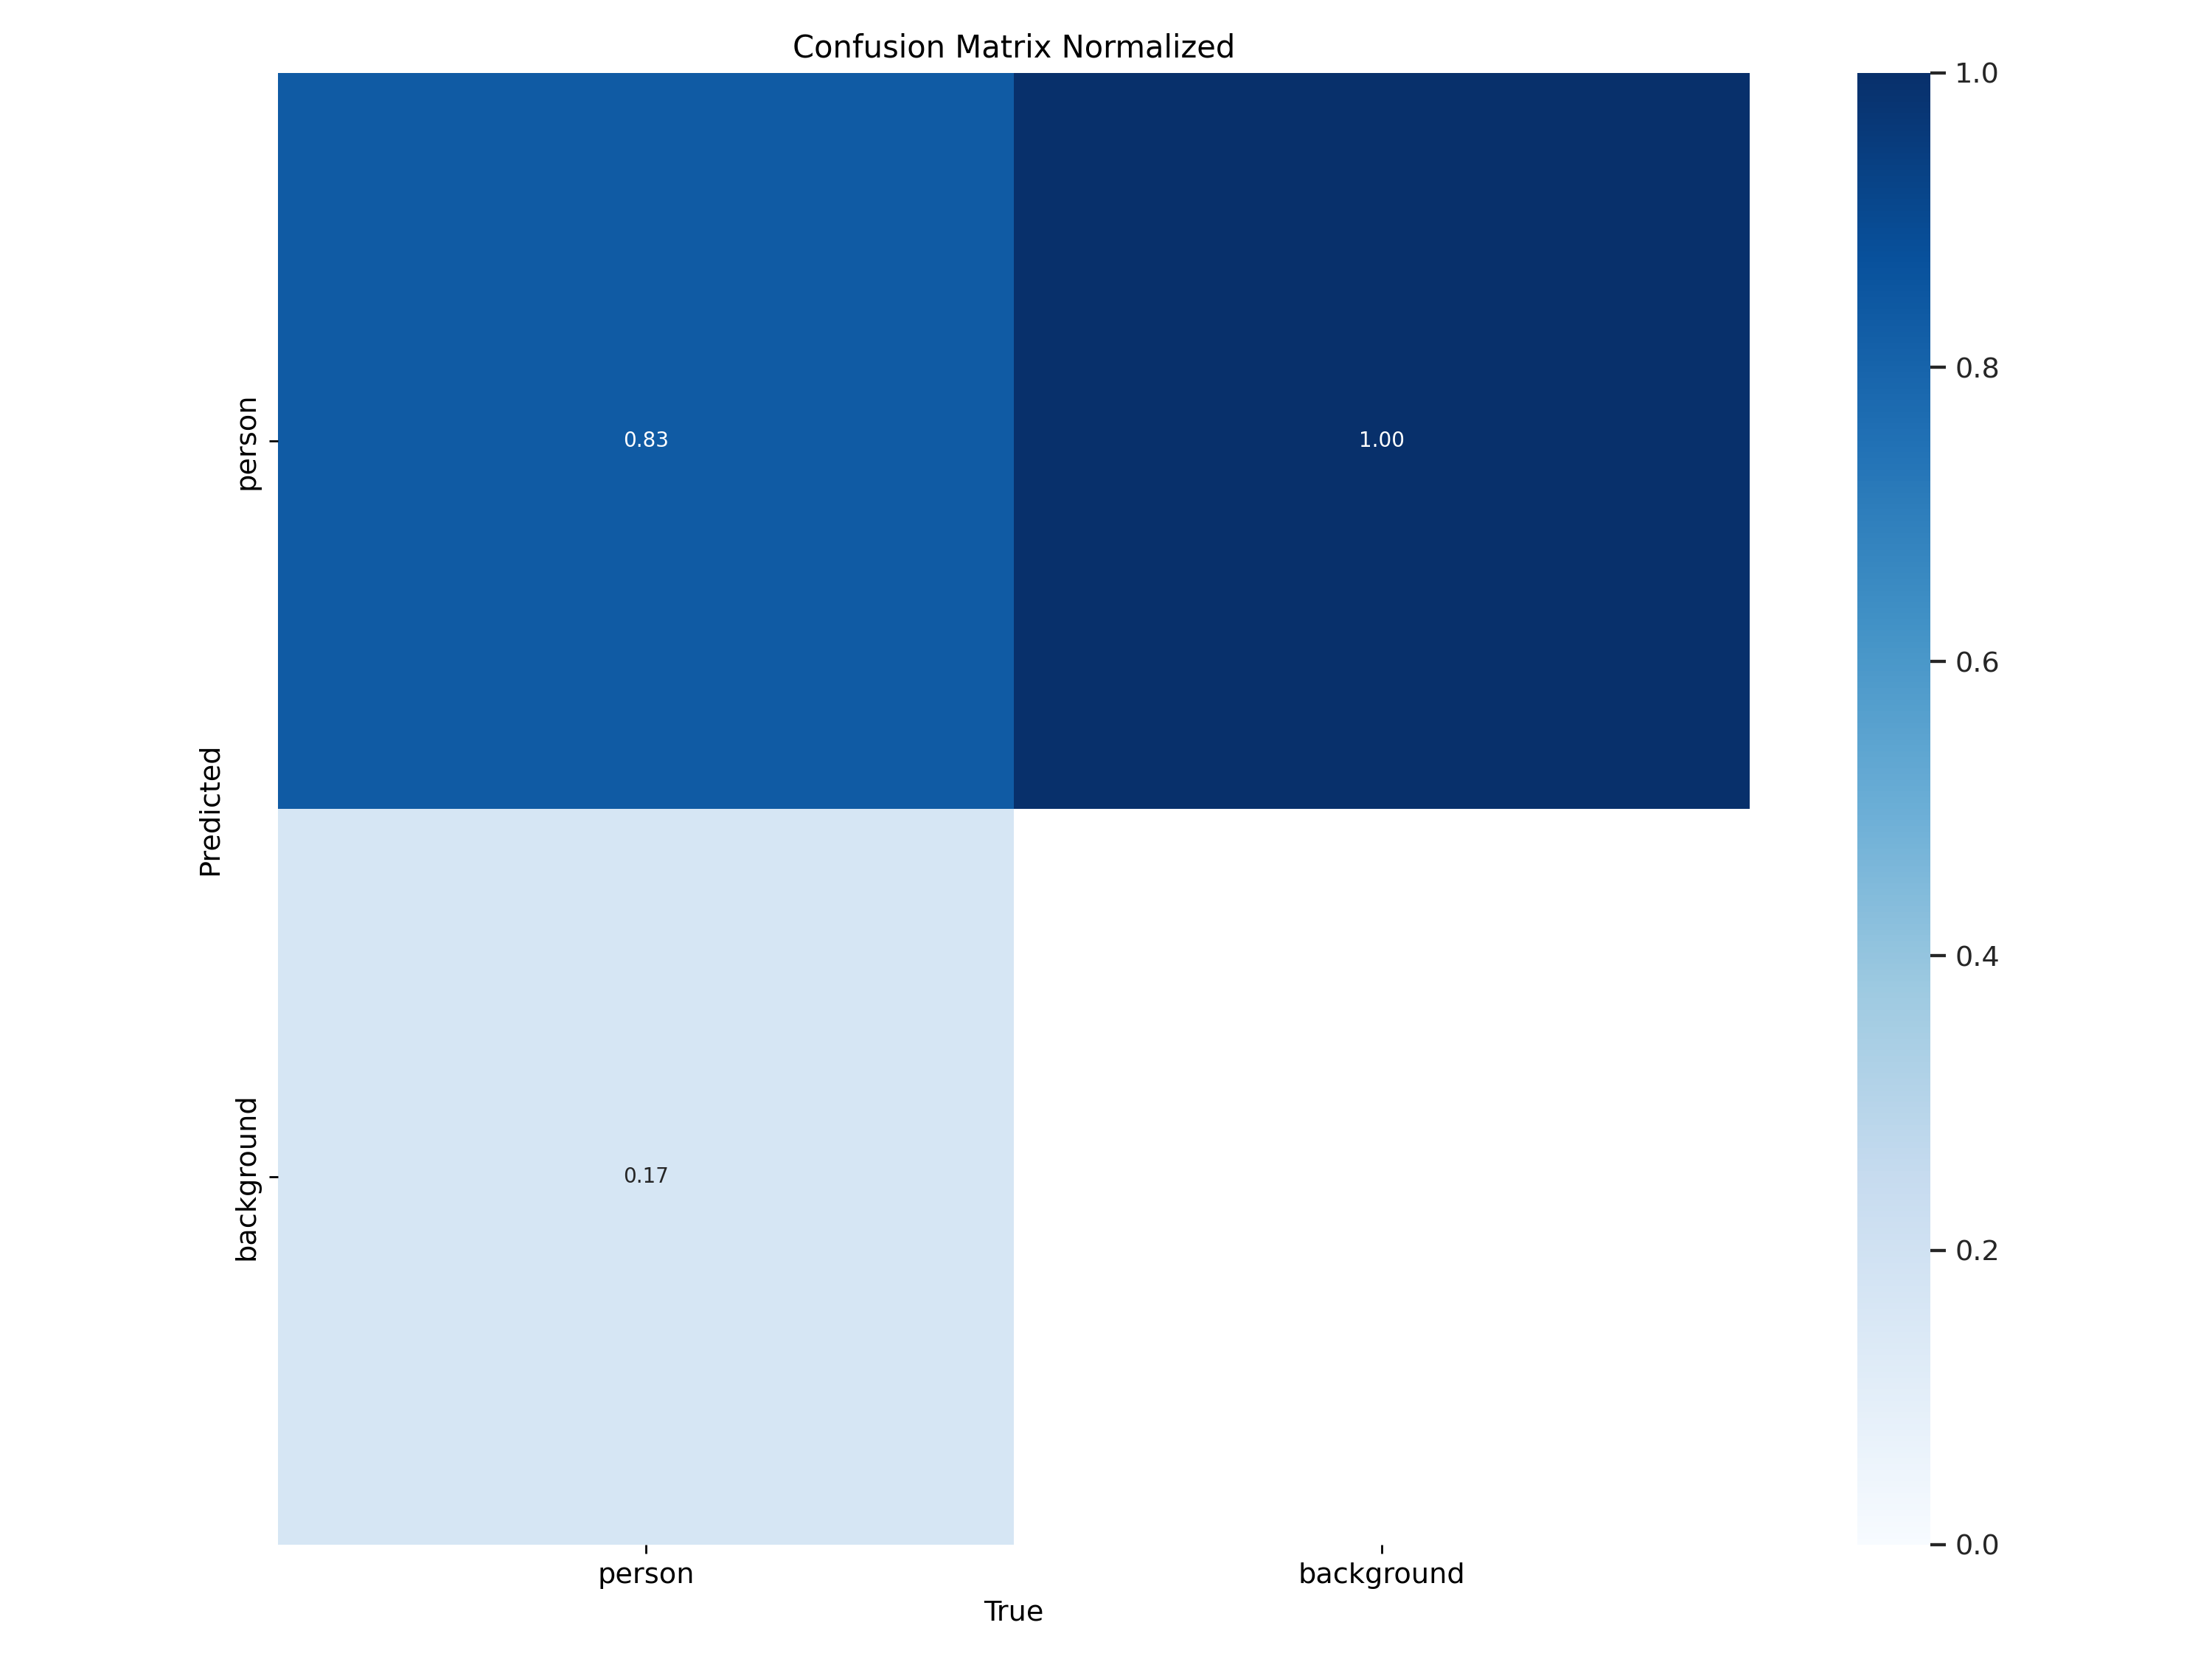

In [7]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/confusion_matrix_normalized.png', width=600)

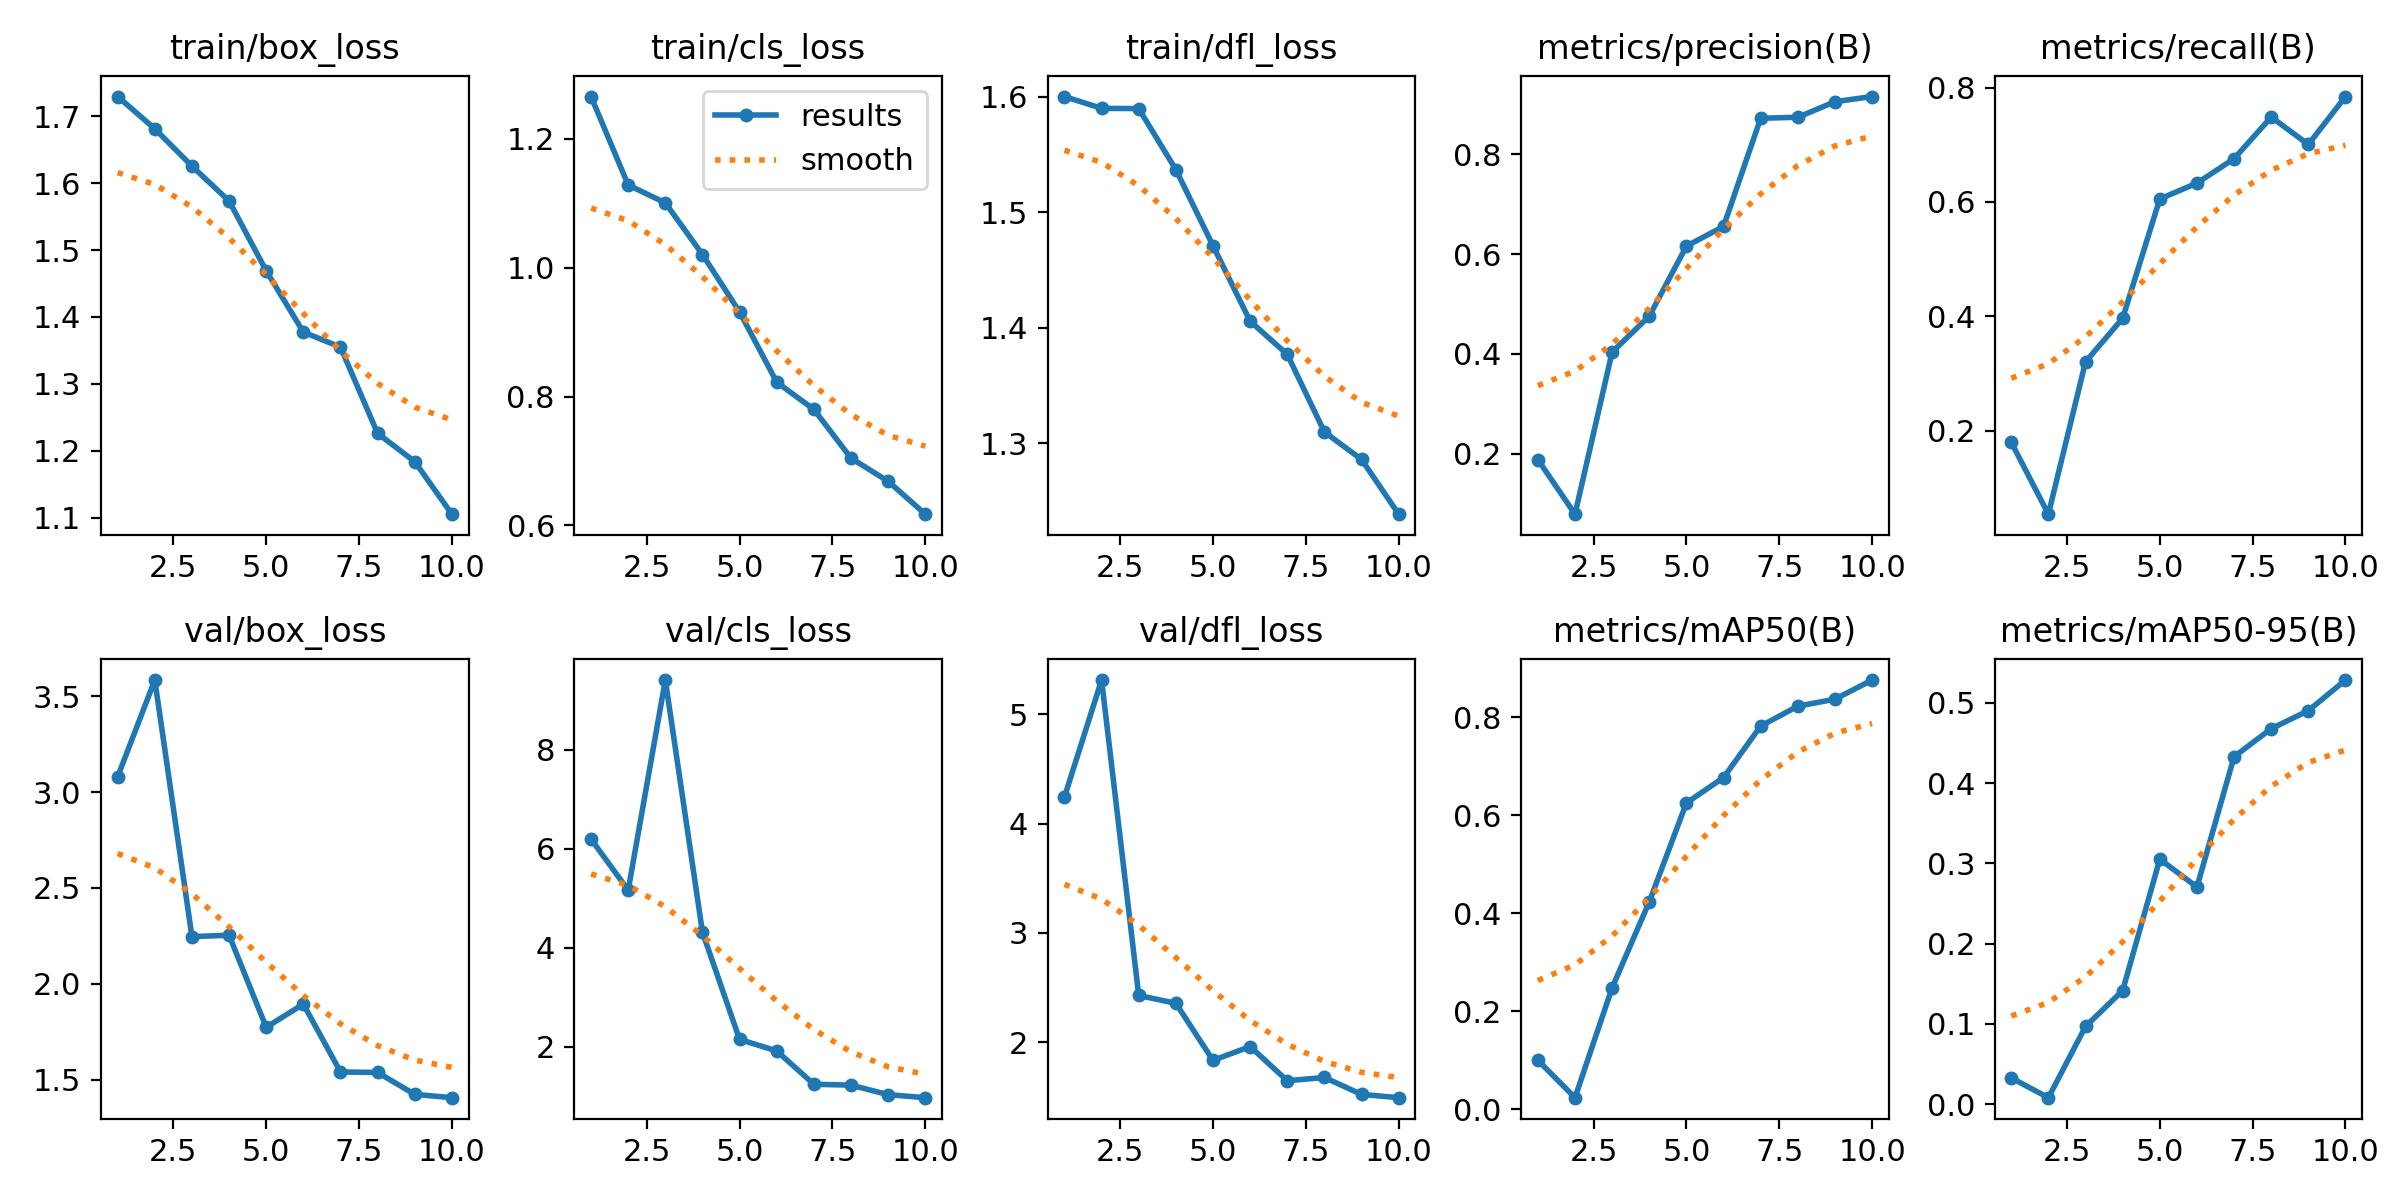

In [9]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/results.png', width=600)

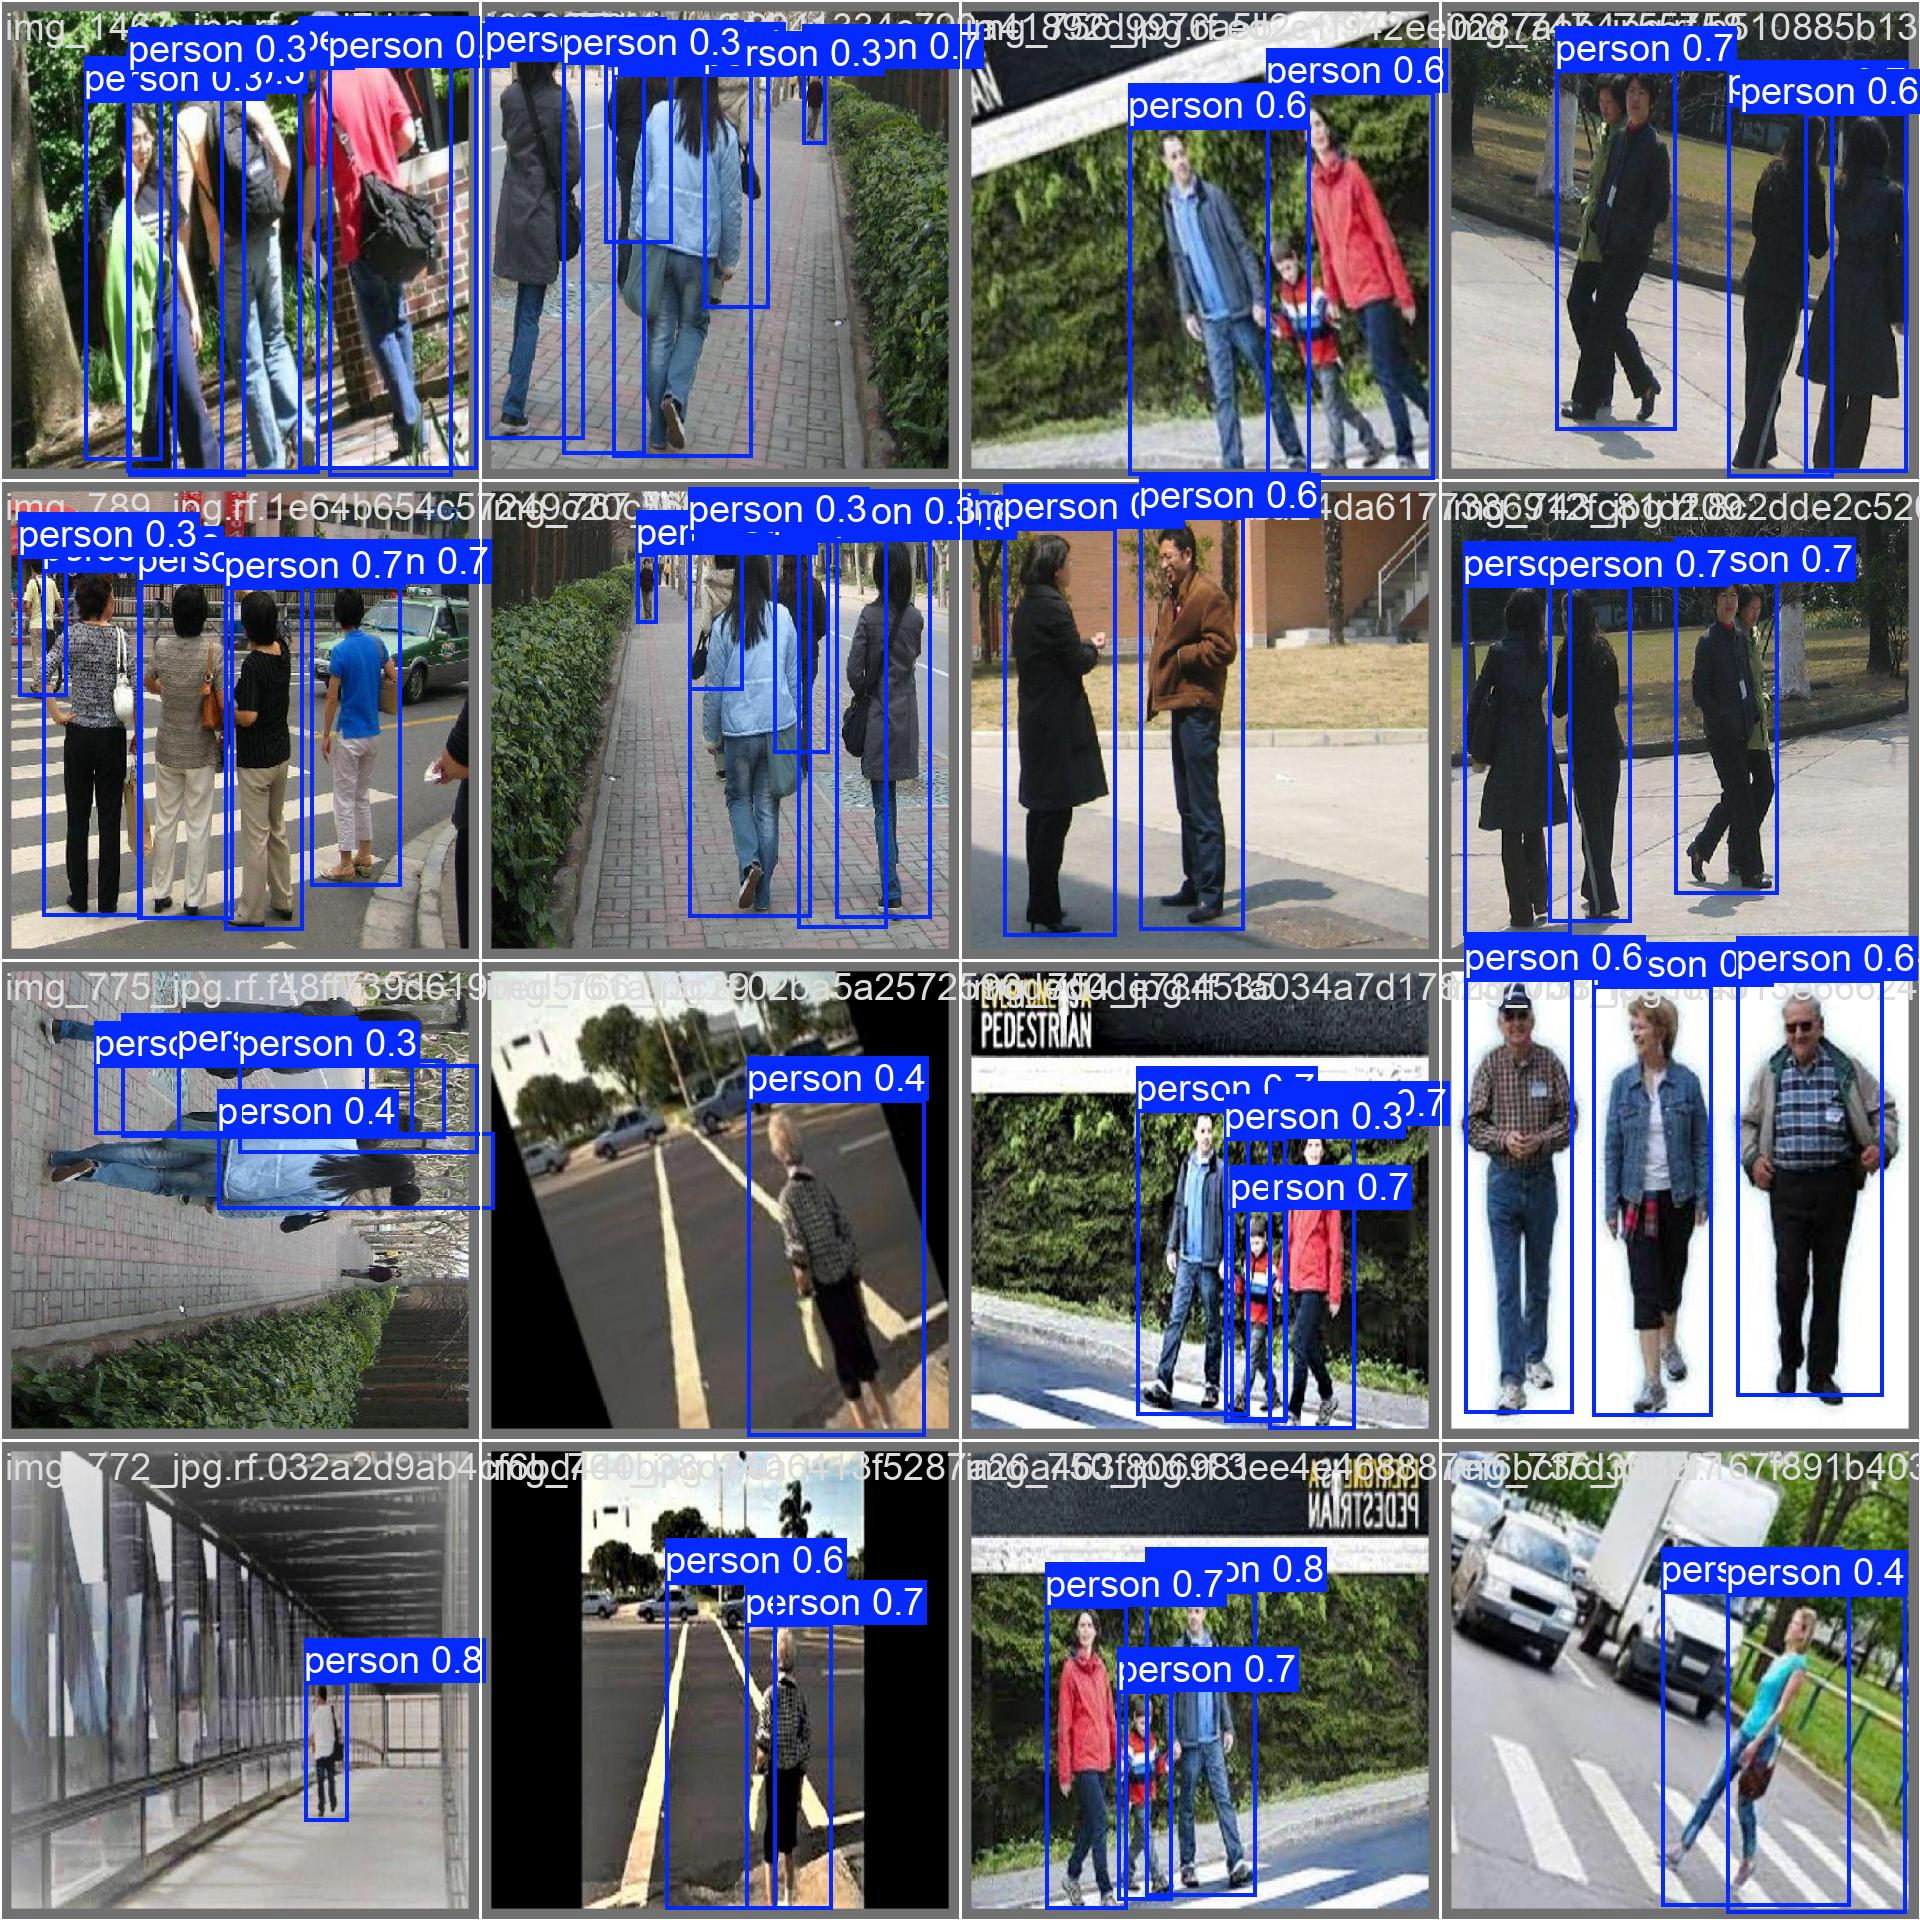

In [10]:
from IPython.display import Image as IPyImage

IPyImage(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Валидация fine-tuned модели

In [12]:
!yolo task=detect mode=val model={HOME}/runs/detect/train/weights/best.pt data={dataset.location}/data.yaml

Ultralytics 8.3.82 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs
val: Scanning /content/Pestrian-volume-1/valid/labels.cache... 125 images, 0 backgrounds, 0 corrupt: 100% 125/125 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 8/8 [00:04<00:00,  1.65it/s]
                   all        125        334      0.916      0.784      0.875      0.528
Speed: 3.2ms preprocess, 23.7ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/val2
💡 Learn more at https://docs.ultralytics.com/modes/val


## Измерение инференса модели

In [14]:
!yolo task=detect mode=predict model={HOME}/runs/detect/train/weights/best.pt conf=0.25 source={dataset.location}/test/images save=True

Ultralytics 8.3.82 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs

image 1/63 /content/Pestrian-volume-1/test/images/F01_png.rf.c03e23195764b608953d3e6a19171326.jpg: 640x640 2 persons, 36.8ms
image 2/63 /content/Pestrian-volume-1/test/images/F07_png.rf.72983408c78d264f306420e60d6c7d70.jpg: 640x640 4 persons, 36.8ms
image 3/63 /content/Pestrian-volume-1/test/images/F13_png.rf.a27cc4294676ace15a27373285aba22f.jpg: 640x640 1 person, 36.8ms
image 4/63 /content/Pestrian-volume-1/test/images/F28_png.rf.c6f56035d82d17ae87e0c54fcf56eab0.jpg: 640x640 3 persons, 36.8ms
image 5/63 /content/Pestrian-volume-1/test/images/F39_png.rf.c40f2f632876bac05aa4fb2a54ba321f.jpg: 640x640 2 persons, 36.8ms
image 6/63 /content/Pestrian-volume-1/test/images/F58_png.rf.1725ce5e0476e9901cde8ba835c22541.jpg: 640x640 5 persons, 36.8ms
image 7/63 /content/Pestrian-volume-1/test/images/F68_png.rf.a0d51541fbe5e5b0da977d

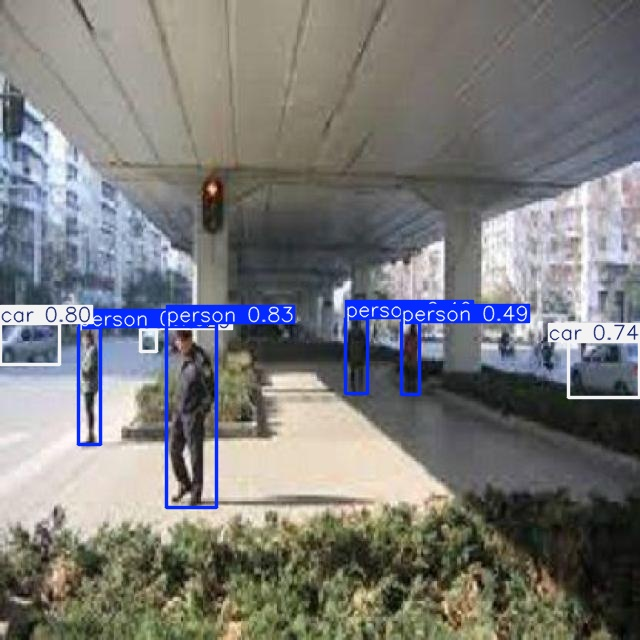

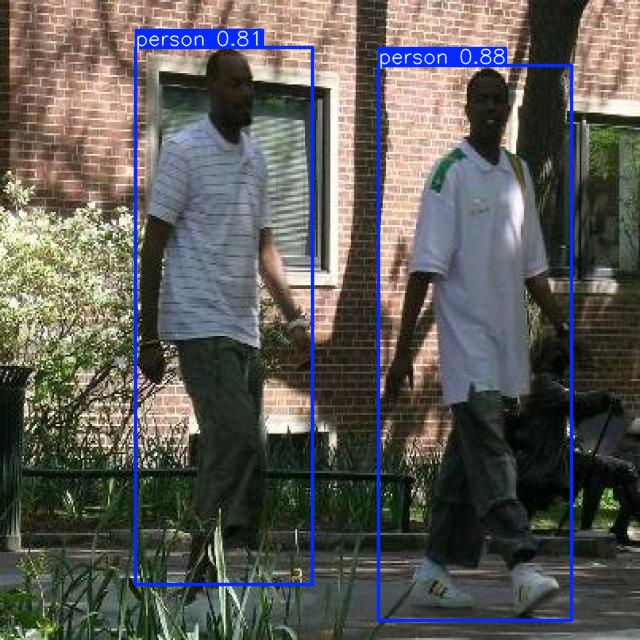

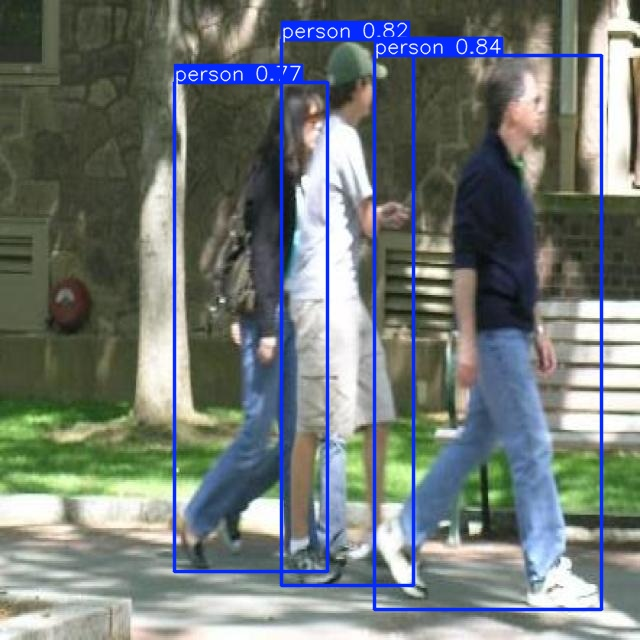

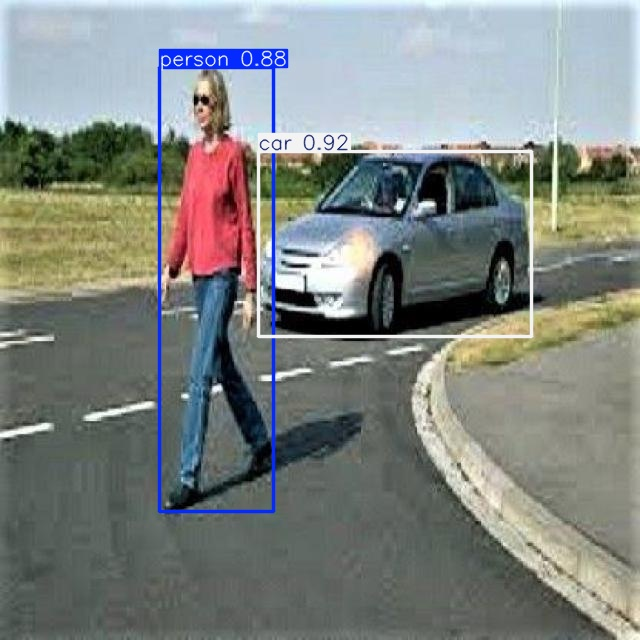

In [15]:
import glob
import os
from IPython.display import Image as IPyImage, display

latest_folder = max(glob.glob('/content/runs/detect/predict/'), key=os.path.getmtime)
for img in glob.glob(f'{latest_folder}/*.jpg')[:4]:
    display(IPyImage(filename=img, width=600))
    print("\n")

## Экспорт модели в onnx (опционально, тк в .pt модель уже есть)

In [16]:
from ultralytics import YOLO
model = YOLO("/content/runs/detect/train/weights/best.pt")
model.export(format="onnx")

Ultralytics 8.3.82 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11m summary (fused): 125 layers, 20,030,803 parameters, 0 gradients, 67.6 GFLOPs

PyTorch: starting from '/content/runs/detect/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (38.6 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 226.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.9/142.9 kB 343.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.5/291.5 MB 220.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 186.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 308.7 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 17.8s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun com

'/content/runs/detect/train/weights/best.onnx'